# Avance 2 — Ingeniería de Características (Feature Engineering) y Selección/Extracción de Características  
**Objetivo del proyecto:** predecir **Producción (kg)** y habilitar análisis para **optimización del proceso**.

---

## 2.3 Crear nuevas características para mejorar el rendimiento de los modelos  
## 2.4 Mitigar el riesgo de características sesgadas y acelerar la convergencia de algunos algoritmos  

### Enfoque
En esta fase (CRISP-ML: *Data Preparation*), convertimos datos crudos en variables útiles para ML mediante:
- **Generación de nuevas características**
- **Discretización / binning**
- **Codificación** (one-hot, ordinal, frequency)
- **Escalamiento** (estandarización / min-max)
- **Transformación** (log, Yeo–Johnson)
- **Selección / extracción** (umbral de varianza, correlación, ANOVA, chi-cuadrado, PCA, FA)

> Todas las técnicas se justifican en su respectiva sección.

---

## Especificación de entrega
- La libreta se ejecuta **de principio a fin** en orden **secuencial**.
- El nombre final sugerido es: `Avance2.#Equipo.ipynb` (renómbralo con tu número de equipo antes de subirlo a GitHub).


In [3]:
# ============================
# 0) Imports + Configuración
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Mostrar más columnas al inspeccionar
pd.set_option("display.max_columns", 200)

# Seaborn (opcional para gráficas; NO obligatorio)
try:
    import seaborn as sns
    sns.set(style="whitegrid")
    HAVE_SNS = True
except Exception:
    HAVE_SNS = False

# Statsmodels (opcional, SOLO si quieres LOWESS)
try:
    import statsmodels.api as sm
    HAVE_STATSMODELS = True
except Exception:
    HAVE_STATSMODELS = False

print("HAVE_SNS:", HAVE_SNS, "| HAVE_STATSMODELS:", HAVE_STATSMODELS)


HAVE_SNS: True | HAVE_STATSMODELS: True


## 1) Carga de datos (raw)

### Justificación
La ingeniería de características requiere partir de las **fuentes crudas** para:
- identificar tipos de dato reales (texto vs numérico)
- detectar valores faltantes y formatos de fecha/hora
- validar consistencia temporal para el *merge* con clima


In [4]:
# ============================
# 1) Carga de datos
# ============================
# Rutas sandbox (si estás usando este entorno)
SANDBOX_UNIFICADO = Path("../data/Dataset.csv")
SANDBOX_CLIMA     = Path("../data/Clima.csv")

# Rutas típicas en repo (si los copias a /data)
REPO_UNIFICADO = Path("../data/Dataset.csv")
REPO_CLIMA     = Path("../data/Clima.csv")

def read_csv_smart(path: Path) -> pd.DataFrame:
    """Lee CSV intentando UTF-8 y fallback a ISO-8859-1."""
    try:
        return pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="ISO-8859-1")

if SANDBOX_UNIFICADO.exists() and SANDBOX_CLIMA.exists():
    df_raw = read_csv_smart(SANDBOX_UNIFICADO)
    clima_raw = read_csv_smart(SANDBOX_CLIMA)
    print("Leyendo desde /mnt/data (sandbox)")
else:
    df_raw = read_csv_smart(REPO_UNIFICADO)
    clima_raw = read_csv_smart(REPO_CLIMA)
    print("Leyendo desde ../data (repo)")

print("Dataset_Unificado:", df_raw.shape)
print("Clima:", clima_raw.shape)
df_raw.head()


Leyendo desde /mnt/data (sandbox)
Dataset_Unificado: (24233, 22)
Clima: (5880, 6)


,Hora de inicio,Número de ordeño,Duración (mm:ss),Producción (kg),Intervalo de ordeño (hh:mm),Duracion de Incremento,Duracion de Decremento,Tiempo de Incremento,Tiempo de Decremento,Ubre,Pezón,Destino Leche,Razón de la desviación,Programa de lavado,MS,Usuario,Tipo de evento,Fecha del evento,Descripción,Usuario.1,Comentario,Num Lactacion
0,01/01/2025 08:33,1,06:08,14.07,09:21,2.81,3.08,4.50,3.68,0.0,NaN,Tanque,NaN,NaN,VMS 1,NaN,Cambio de grup,02/08/2021 00:00,"2, VMS 2 -> 3, VMS 3",User1,NaN,1.0
1,01/01/2025 21:11,2,08:01,19.25,12:32,3.76,4.46,6.03,5.00,0.0,NaN,Tanque,NaN,NaN,VMS 1,NaN,Control de Gest,02/07/2031 00:00,+,User1,CARGADA DE 153,1.0
2,02/01/2025 06:29,1,06:26,13.96,09:09,2.95,3.24,4.38,3.39,0.0,NaN,Tanque,NaN,NaN,VMS 1,NaN,Invitación Visita,02/07/2031 00:00,"31/07/2025, Reconfirmacion 2 (150-\n160 dias)",DR RAFA (,NaN,1.0
3,02/01/2025 21:21,2,07:34,22.74,14:45,4.69,5.16,7.10,5.79,0.0,NaN,Tanque,NaN,NaN,VMS 1,NaN,Control de Gest,02/05/2029 00:00,+,User1,cargada de 90,1.0
4,03/01/2025 08:30,1,07:28,19.27,11:01,4.10,4.36,6.07,4.74,0.0,NaN,Tanque,NaN,NaN,VMS 1,NaN,Invitación Visita,02/05/2029 00:00,"29/05/2025, Reconfirmacion 1 (90-\n110 dias)",DR RAFA (,NaN,1.0


In [5]:
# Inspección rápida de columnas y tipos
df_raw.dtypes


Hora de inicio                     str
Número de ordeño                 int64
Duración (mm:ss)                   str
Producción (kg)                float64
Intervalo de ordeño (hh:mm)        str
Duracion de Incremento         float64
Duracion de Decremento         float64
Tiempo de Incremento           float64
Tiempo de Decremento           float64
Ubre                           float64
Pezón                              str
Destino Leche                      str
Razón de la desviación             str
Programa de lavado                 str
MS                                 str
Usuario                        float64
Tipo de evento                     str
Fecha del evento                   str
Descripción                        str
Usuario.1                          str
Comentario                         str
Num Lactacion                  float64
dtype: object

In [6]:
clima_raw.dtypes


time                        str
temperature_2m          float64
relative_humidity_2m      int64
pressure_msl            float64
precipitation           float64
wind_speed_10m          float64
dtype: object

## 2) Limpieza mínima y parsing de fechas

### Justificación
Los modelos requieren variables numéricas consistentes.  
En particular, la integración con el clima requiere timestamps comparables y ordenados.

- `Hora de inicio` viene en formato `dd/mm/aaaa hh:mm`
- `time` viene en formato ISO

Se crean timestamps:
- `ts_inicio` (eventos/ordeños)
- `ts_clima` (clima por hora)


In [7]:
df = df_raw.copy()
clima = clima_raw.copy()

df["ts_inicio"] = pd.to_datetime(df["Hora de inicio"], dayfirst=True, errors="coerce")
clima["ts_clima"] = pd.to_datetime(clima["time"], errors="coerce")

# Eliminar filas sin timestamp (no se pueden usar para merge ni features temporales)
df = df.dropna(subset=["ts_inicio"]).sort_values("ts_inicio").reset_index(drop=True)
clima = clima.dropna(subset=["ts_clima"]).sort_values("ts_clima").reset_index(drop=True)

print("df:", df.shape, "| clima:", clima.shape)
df[["Hora de inicio", "ts_inicio"]].head()


df: (24233, 23) | clima: (5880, 7)


,Hora de inicio,ts_inicio
0,01/01/2025 00:09,2025-01-01 00:09:00
1,01/01/2025 00:19,2025-01-01 00:19:00
2,01/01/2025 00:33,2025-01-01 00:33:00
3,01/01/2025 00:40,2025-01-01 00:40:00
4,01/01/2025 00:54,2025-01-01 00:54:00


## 3) Conversión de duraciones (texto → numérico)

### Justificación
Campos como `mm:ss` o `hh:mm` son textuales; convertirlos a segundos/minutos:
- reduce sesgo por representación de texto
- permite escalamiento y transformaciones
- mejora modelos que explotan relaciones cuantitativas

Se crean:
- `duracion_s` a partir de `Duración (mm:ss)`
- `intervalo_ordeño_min` a partir de `Intervalo de ordeño (hh:mm)`


In [8]:
def mmss_to_seconds(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if ":" not in s:
        return np.nan
    parts = s.split(":")
    if len(parts) != 2:
        return np.nan
    mm, ss = parts
    try:
        return int(mm) * 60 + int(ss)
    except ValueError:
        return np.nan

def hhmm_to_minutes(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if ":" not in s:
        return np.nan
    parts = s.split(":")
    if len(parts) != 2:
        return np.nan
    hh, mm = parts
    try:
        return int(hh) * 60 + int(mm)
    except ValueError:
        return np.nan

df["duracion_s"] = df["Duración (mm:ss)"].apply(mmss_to_seconds) if "Duración (mm:ss)" in df.columns else np.nan
df["intervalo_ordeño_min"] = df["Intervalo de ordeño (hh:mm)"].apply(hhmm_to_minutes) if "Intervalo de ordeño (hh:mm)" in df.columns else np.nan

# Coerción de columnas numéricas típicas (si existen)
num_cols = [
    "Producción (kg)",
    "Duracion de Incremento",
    "Duracion de Decremento",
    "Tiempo de Incremento",
    "Tiempo de Decremento",
    "Ubre",
    "Pezón",
    "Número de ordeño",
    "Num Lactacion",
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df[[c for c in ["Duración (mm:ss)", "duracion_s", "Intervalo de ordeño (hh:mm)", "intervalo_ordeño_min", "Producción (kg)"] if c in df.columns]].head()


,Duración (mm:ss),duracion_s,Intervalo de ordeño (hh:mm),intervalo_ordeño_min,Producción (kg)
0,08:33,513.0,10:03,603.0,18.03
1,07:50,470.0,08:01,481.0,17.76
2,06:09,369.0,09:32,572.0,22.35
3,13:11,791.0,27:13:00,NaN,13.92
4,06:22,382.0,10:56,656.0,16.72


## 4) Integración con clima (feature enrichment)

### Justificación
Las variables ambientales (temperatura, humedad, precipitación, etc.) pueden afectar el proceso y, por tanto, la producción.  
Dado que el clima está **por hora**, se usa `merge_asof` para unir cada evento con el registro horario más cercano (tolerancia ±2h) evitando emparejamientos absurdos.

> Esta estrategia es apropiada cuando la variable exógena se mide en intervalos discretos (hora) y el evento ocurre en un instante dentro de ese intervalo.


In [9]:
# Normalizar nombres del clima (si coinciden con open-meteo)
clima_feats = clima.rename(columns={
    "temperature_2m": "temp_C",
    "relative_humidity_2m": "hum_rel",
    "pressure_msl": "pres_msl",
    "precipitation": "precip_mm",
    "wind_speed_10m": "wind_ms",
}).copy()

clima_keep = ["ts_clima"]
for c in ["temp_C", "hum_rel", "pres_msl", "precip_mm", "wind_ms"]:
    if c in clima_feats.columns:
        clima_keep.append(c)

clima_feats = clima_feats[clima_keep].sort_values("ts_clima").reset_index(drop=True)

df = pd.merge_asof(
    df.sort_values("ts_inicio"),
    clima_feats,
    left_on="ts_inicio",
    right_on="ts_clima",
    direction="nearest",
    tolerance=pd.Timedelta("2H"),
)

df[["ts_inicio"] + [c for c in ["temp_C","hum_rel","pres_msl","precip_mm","wind_ms"] if c in df.columns]].head()


/var/folders/8n/ss0jgxw12y974534qchnd3jw0000gn/T/ipykernel_35258/1097836909.py:23: Pandas4Warning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  tolerance=pd.Timedelta("2H"),


,ts_inicio,temp_C,hum_rel,pres_msl,precip_mm,wind_ms
0,2025-01-01 00:09:00,11.6,47.0,1019.2,0.0,8.5
1,2025-01-01 00:19:00,11.6,47.0,1019.2,0.0,8.5
2,2025-01-01 00:33:00,10.6,52.0,1019.5,0.0,8.9
3,2025-01-01 00:40:00,10.6,52.0,1019.5,0.0,8.9
4,2025-01-01 00:54:00,10.6,52.0,1019.5,0.0,8.9


## 5) 2.3 — Generación de nuevas características

### 5.1 Features temporales (calendario + cíclicas)
**Justificación:** los fenómenos estacionales y de turno/horario suelen ser periódicos.  
Se usan representaciones cíclicas (seno/coseno) para evitar discontinuidades (23→0).

Se crean:
- `hour`, `dow`, `month`, `dayofyear`, `is_weekend`
- `hour_sin`, `hour_cos`, `doy_sin`, `doy_cos`


In [10]:
ts = df["ts_inicio"]
df["hour"] = ts.dt.hour
df["dow"] = ts.dt.dayofweek
df["month"] = ts.dt.month
df["dayofyear"] = ts.dt.dayofyear
df["is_weekend"] = (df["dow"] >= 5).astype(int)

df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24.0)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24.0)
df["doy_sin"]  = np.sin(2*np.pi*df["dayofyear"]/366.0)
df["doy_cos"]  = np.cos(2*np.pi*df["dayofyear"]/366.0)

df[["ts_inicio","hour","dow","month","is_weekend","hour_sin","hour_cos"]].head()


,ts_inicio,hour,dow,month,is_weekend,hour_sin,hour_cos
0,2025-01-01 00:09:00,0,2,1,0,0.0,1.0
1,2025-01-01 00:19:00,0,2,1,0,0.0,1.0
2,2025-01-01 00:33:00,0,2,1,0,0.0,1.0
3,2025-01-01 00:40:00,0,2,1,0,0.0,1.0
4,2025-01-01 00:54:00,0,2,1,0,0.0,1.0


### 5.2 Features de eficiencia y dinámica del proceso
**Justificación:** para optimización, interesa medir eficiencia (kg/min) y proporciones de fases (rampas) normalizadas por la duración total.

Se crean:
- `duracion_min`
- `kg_por_min`
- `inc_ratio`, `dec_ratio` (si existen columnas de tiempos)


In [11]:
df["duracion_min"] = df["duracion_s"] / 60.0

df["kg_por_min"] = np.where(
    df["duracion_min"] > 0,
    df["Producción (kg)"] / df["duracion_min"],
    np.nan
) if "Producción (kg)" in df.columns else np.nan

if "Tiempo de Incremento" in df.columns:
    df["inc_ratio"] = np.where(df["duracion_s"] > 0, df["Tiempo de Incremento"] / df["duracion_s"], np.nan)
if "Tiempo de Decremento" in df.columns:
    df["dec_ratio"] = np.where(df["duracion_s"] > 0, df["Tiempo de Decremento"] / df["duracion_s"], np.nan)

df[[c for c in ["Producción (kg)","duracion_s","duracion_min","kg_por_min","inc_ratio","dec_ratio"] if c in df.columns]].head()


,Producción (kg),duracion_s,duracion_min,kg_por_min,inc_ratio,dec_ratio
0,18.03,513.0,8.550000,2.108772,0.006608,0.010819
1,17.76,470.0,7.833333,2.267234,0.014511,0.015596
2,22.35,369.0,6.150000,3.634146,0.017940,0.017588
3,13.92,791.0,13.183333,1.055879,0.006928,0.000000
4,16.72,382.0,6.366667,2.626178,NaN,0.017565


## 6) Discretización / binning (2.3)

### Justificación
El binning ayuda a:
- capturar relaciones no lineales (por rangos)
- reducir sensibilidad a ruido (smoothing interpretativo)
- hacer *insights* operativos (ej. “duración 6–7 min”)

Ejemplos:
- Binning de `duracion_min`
- Binning de `temp_C`


In [12]:
# Binning de duración (cuantiles para balancear bins)
if "duracion_min" in df.columns:
    df["duracion_bin_q"] = pd.qcut(df["duracion_min"], q=5, duplicates="drop")

# Binning de temperatura (rango fijo si existe)
if "temp_C" in df.columns:
    df["temp_bin"] = pd.cut(df["temp_C"], bins=[-10, 0, 10, 20, 30, 40, 60])

df[[c for c in ["duracion_min","duracion_bin_q","temp_C","temp_bin"] if c in df.columns]].head()


,duracion_min,duracion_bin_q,temp_C,temp_bin
0,8.550000,"(8.033, 9.767]",11.6,"(10, 20]"
1,7.833333,"(6.9, 8.033]",11.6,"(10, 20]"
2,6.150000,"(5.917, 6.9]",10.6,"(10, 20]"
3,13.183333,"(9.767, 23.717]",10.6,"(10, 20]"
4,6.366667,"(5.917, 6.9]",10.6,"(10, 20]"


## 7) Codificación de variables categóricas (2.3)

### Justificación
Los modelos ML requieren variables numéricas.  
Se aplican:
- **One-hot** para baja cardinalidad (pocas categorías)
- **Frequency encoding** para alta cardinalidad (ej. `Usuario`), evitando explosión dimensional.

> Para tareas de regresión, chi-cuadrado requiere variables no negativas y target discretizado; lo aplicaremos más adelante sobre bins del target (aproximación de dependencia).


In [13]:
cat_cols = [
    "Destino Leche",
    "Tipo de evento",
    "MS",
    "Usuario",
    "Usuario.1",
    "Programa de lavado",
    "Razón de la desviación",
    "duracion_bin_q",
    "temp_bin",
]
cat_cols = [c for c in cat_cols if c in df.columns]

for c in cat_cols:
    df[c] = df[c].astype(str).str.strip()
    df.loc[df[c].isin(["nan","NaN","None",""]), c] = np.nan

def frequency_encode(series: pd.Series) -> pd.Series:
    freq = series.value_counts(dropna=True)
    return series.map(freq).fillna(0).astype(float)

high_card, low_card = [], []
for c in cat_cols:
    nuniq = df[c].nunique(dropna=True)
    (high_card if nuniq > 30 else low_card).append(c)

for c in high_card:
    df[c + "_freq"] = frequency_encode(df[c])

df_ohe = pd.get_dummies(df[low_card], prefix=low_card, dummy_na=True) if low_card else pd.DataFrame(index=df.index)

print("One-hot:", low_card)
print("Freq-encoding:", high_card)
df_ohe.head()


One-hot: ['Destino Leche', 'Tipo de evento', 'MS', 'Usuario', 'Usuario.1', 'Programa de lavado', 'Razón de la desviación', 'duracion_bin_q', 'temp_bin']
Freq-encoding: []


,Destino Leche_Divert 3,Destino Leche_Dr,Destino Leche_Drenaje,Destino Leche_Ta,Destino Leche_Tanque,Destino Leche_nan,Tipo de evento_Aborto,Tipo de evento_Cambio ID,Tipo de evento_Cambio ID Tran,Tipo de evento_Cambio de grup,Tipo de evento_Cambio de medi,Tipo de evento_Cambio tabla ali,Tipo de evento_Celo,Tipo de evento_Cita de vacunaci,Tipo de evento_Condición corpo,Tipo de evento_Control de Gest,Tipo de evento_Diagnósticos/Tr,Tipo de evento_Entrada,Tipo de evento_Inseminación,Tipo de evento_Invitación Visita,Tipo de evento_Notas,Tipo de evento_Parto,Tipo de evento_Peso,Tipo de evento_Revisión del est,Tipo de evento_Secado,Tipo de evento_Temperatura Re,Tipo de evento_nan,MS_VM,MS_VMS 1,MS_VMS 2,MS_VMS 3,MS_nan,Usuario_nan,Usuario.1_Admin,Usuario.1_Alfredo,Usuario.1_DR RAFA (,Usuario.1_DelproClien,Usuario.1_Dra Guadal,Usuario.1_Dra. Vázqu,Usuario.1_Gabriel,Usuario.1_Jorge,Usuario.1_Jose Luis,Usuario.1_Jose Zapat,Usuario.1_MVZ. GUA,Usuario.1_Matías,Usuario.1_Rodrigo,Usuario.1_Roma,Usuario.1_UnknownBr,Usuario.1_User1,Usuario.1_mvz LUIS Z,Usuario.1_mvz juan,Usuario.1_nan,Programa de lavado_Local Aclarado,Programa de lavado_nan,Razón de la desviación_Sangre por pezón por encima del umbral,Razón de la desviación_Separada manualmente,Razón de la desviación_nan,"duracion_bin_q_(0.766, 5.917]","duracion_bin_q_(5.917, 6.9]","duracion_bin_q_(6.9, 8.033]","duracion_bin_q_(8.033, 9.767]","duracion_bin_q_(9.767, 23.717]",duracion_bin_q_nan,"temp_bin_(0.0, 10.0]","temp_bin_(10.0, 20.0]","temp_bin_(20.0, 30.0]","temp_bin_(30.0, 40.0]",temp_bin_nan
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False
4,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False


## 8) Construcción de matriz de features (X) y target (y)

- Target: `Producción (kg)`  
- X: numéricas derivadas + freq encodings + one-hot

> Nota: en esta entrega, la prioridad es la **fase de preparación**. El modelo final puede ajustarse después, pero incluimos un baseline para validar señal.


In [14]:
target_col = "Producción (kg)"
assert target_col in df.columns, "No se encontró la columna target 'Producción (kg)'."

base_feature_cols = [
    # Proceso
    "duracion_s","duracion_min","intervalo_ordeño_min",
    "Duracion de Incremento","Duracion de Decremento",
    "Tiempo de Incremento","Tiempo de Decremento",
    "Ubre","Pezón","Número de ordeño","Num Lactacion",
    # Tiempo (cíclicas)
    "hour","dow","month","dayofyear","is_weekend",
    "hour_sin","hour_cos","doy_sin","doy_cos",
    # Clima
    "temp_C","hum_rel","pres_msl","precip_mm","wind_ms",
    # Diagnóstico
    "kg_por_min","inc_ratio","dec_ratio",
]
base_feature_cols = [c for c in base_feature_cols if c in df.columns]

freq_cols = [c for c in df.columns if c.endswith("_freq")]

X_num = df[base_feature_cols + freq_cols].copy()
X_cat = df_ohe.copy()

X = pd.concat([X_num, X_cat], axis=1)
y = df[target_col].copy()

# Filtrar filas sin target
mask = y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

print("X:", X.shape, "| y:", y.shape)
X.head()


X: (24233, 96) | y: (24233,)


,duracion_s,duracion_min,intervalo_ordeño_min,Duracion de Incremento,Duracion de Decremento,Tiempo de Incremento,Tiempo de Decremento,Ubre,Pezón,Número de ordeño,Num Lactacion,hour,dow,month,dayofyear,is_weekend,hour_sin,hour_cos,doy_sin,doy_cos,temp_C,hum_rel,pres_msl,precip_mm,wind_ms,kg_por_min,inc_ratio,dec_ratio,Destino Leche_Divert 3,Destino Leche_Dr,Destino Leche_Drenaje,Destino Leche_Ta,Destino Leche_Tanque,Destino Leche_nan,Tipo de evento_Aborto,Tipo de evento_Cambio ID,Tipo de evento_Cambio ID Tran,Tipo de evento_Cambio de grup,Tipo de evento_Cambio de medi,Tipo de evento_Cambio tabla ali,Tipo de evento_Celo,Tipo de evento_Cita de vacunaci,Tipo de evento_Condición corpo,Tipo de evento_Control de Gest,Tipo de evento_Diagnósticos/Tr,Tipo de evento_Entrada,Tipo de evento_Inseminación,Tipo de evento_Invitación Visita,Tipo de evento_Notas,Tipo de evento_Parto,Tipo de evento_Peso,Tipo de evento_Revisión del est,Tipo de evento_Secado,Tipo de evento_Temperatura Re,Tipo de evento_nan,MS_VM,MS_VMS 1,MS_VMS 2,MS_VMS 3,MS_nan,Usuario_nan,Usuario.1_Admin,Usuario.1_Alfredo,Usuario.1_DR RAFA (,Usuario.1_DelproClien,Usuario.1_Dra Guadal,Usuario.1_Dra. Vázqu,Usuario.1_Gabriel,Usuario.1_Jorge,Usuario.1_Jose Luis,Usuario.1_Jose Zapat,Usuario.1_MVZ. GUA,Usuario.1_Matías,Usuario.1_Rodrigo,Usuario.1_Roma,Usuario.1_UnknownBr,Usuario.1_User1,Usuario.1_mvz LUIS Z,Usuario.1_mvz juan,Usuario.1_nan,Programa de lavado_Local Aclarado,Programa de lavado_nan,Razón de la desviación_Sangre por pezón por encima del umbral,Razón de la desviación_Separada manualmente,Razón de la desviación_nan,"duracion_bin_q_(0.766, 5.917]","duracion_bin_q_(5.917, 6.9]","duracion_bin_q_(6.9, 8.033]","duracion_bin_q_(8.033, 9.767]","duracion_bin_q_(9.767, 23.717]",duracion_bin_q_nan,"temp_bin_(0.0, 10.0]","temp_bin_(10.0, 20.0]","temp_bin_(20.0, 30.0]","temp_bin_(30.0, 40.0]",temp_bin_nan
0,513.0,8.550000,603.0,4.67,4.42,3.39,5.55,0.0,NaN,1,NaN,0,2,1,1,0,0.0,1.0,0.017166,0.999853,11.6,47.0,1019.2,0.0,8.5,2.108772,0.006608,0.010819,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False
1,470.0,7.833333,481.0,3.61,NaN,6.82,7.33,0.0,NaN,1,NaN,0,2,1,1,0,0.0,1.0,0.017166,0.999853,11.6,47.0,1019.2,0.0,8.5,2.267234,0.014511,0.015596,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False
2,369.0,6.150000,572.0,4.52,4.72,6.62,6.49,0.0,NaN,1,3.0,0,2,1,1,0,0.0,1.0,0.017166,0.999853,10.6,52.0,1019.5,0.0,8.9,3.634146,0.017940,0.017588,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False
3,791.0,13.183333,NaN,3.91,4.53,5.48,0.00,0.0,NaN,1,1.0,0,2,1,1,0,0.0,1.0,0.017166,0.999853,10.6,52.0,1019.5,0.0,8.9,1.055879,0.006928,0.000000,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,

## 9) 2.4 — Escalamiento y transformaciones

### 9.1 Estandarización (StandardScaler)
**Justificación:** algoritmos sensibles a escala (regresión lineal, SVM, k-NN, redes) convergen mejor y evitan dominancia por magnitudes.

### 9.2 Min-Max (alternativa)
**Justificación:** útil si se quiere acotar a [0,1] (p.ej. redes neuronales).

### 9.3 Transformaciones (log y Yeo–Johnson)
**Justificación:** reducir asimetría, estabilizar varianza y mitigar outliers.

> Yeo–Johnson soporta cero/negativos; Box–Cox requiere positivos.


In [16]:
from sklearn.preprocessing import PowerTransformer

# ============================
# Yeo–Johnson robusto
# ============================

# Requisitos prácticos:
# - al menos N valores no-NaN en train
# - varianza > 0 (no constante)
MIN_NON_NAN = 30

# Columns numéricas ya definidas como num_features
# X_train_imp y X_test_imp ya están imputadas en num_features con la mediana,
# pero aún puede haber columnas con todo NaN si la mediana fue NaN (columna totalmente vacía).
num_ok = []
num_bad = []

for c in num_features:
    col = X_train_imp[c].to_numpy(dtype=float)
    non_nan = np.isfinite(col).sum()

    # Si está completamente vacía o con muy pocos puntos, no transformar
    if non_nan < MIN_NON_NAN:
        num_bad.append(c)
        continue

    # Si es constante (varianza ~ 0), no transformar
    if np.nanstd(col) < 1e-12:
        num_bad.append(c)
        continue

    num_ok.append(c)

print("Numéricas transformables (YJ):", len(num_ok))
print("Numéricas NO transformables:", len(num_bad))
if len(num_bad) > 0:
    print("Ejemplos NO transformables:", num_bad[:10])

# Construir X_train_yj y X_test_yj (copias)
X_train_yj = X_train_imp.copy()
X_test_yj  = X_test_imp.copy()

# Asegurar que las columnas "malas" no tengan NaN raros: rellena con 0 si siguen NaN
if len(num_bad) > 0:
    X_train_yj[num_bad] = X_train_yj[num_bad].fillna(0)
    X_test_yj[num_bad]  = X_test_yj[num_bad].fillna(0)

# Aplicar Yeo–Johnson SOLO a las columnas válidas
pt = PowerTransformer(method="yeo-johnson", standardize=True)

if len(num_ok) > 0:
    X_train_yj[num_ok] = pt.fit_transform(X_train_imp[num_ok])
    X_test_yj[num_ok]  = pt.transform(X_test_imp[num_ok])
else:
    print("No hay columnas numéricas válidas para Yeo–Johnson. Se omite.")

print("Listo: X_train_yj / X_test_yj")


Numéricas transformables (YJ): 27
Numéricas NO transformables: 1
Ejemplos NO transformables: ['Pezón']
Listo: X_train_yj / X_test_yj


## 10) Visualización: Scatter plots (variables vs Producción)

### Justificación
Los scatter plots permiten:
- detectar no linealidad y saturación (clave para optimización)
- detectar outliers
- priorizar variables para selección

Incluimos:
- scatter simple
- curva de respuesta por bins (interpretable y sin dependencias extra)
- (opcional) LOWESS si `statsmodels` está instalado


In [17]:
# Elegir variables a graficar (ajusta a tu caso)
vars_scatter = [
    "duracion_min",
    "intervalo_ordeño_min",
    "Tiempo de Incremento",
    "Tiempo de Decremento",
    "Duracion de Incremento",
    "Duracion de Decremento",
    "Num Lactacion",
    "Número de ordeño",
    "temp_C",
    "hum_rel",
    "precip_mm",
    "wind_ms",
    "kg_por_min",
]
vars_scatter = [v for v in vars_scatter if v in df.columns]

plot_df = df.loc[mask, vars_scatter + [target_col]].replace([np.inf, -np.inf], np.nan)
print("Variables a graficar:", vars_scatter)
print("Filas:", plot_df.shape[0])


Variables a graficar: ['duracion_min', 'intervalo_ordeño_min', 'Tiempo de Incremento', 'Tiempo de Decremento', 'Duracion de Incremento', 'Duracion de Decremento', 'Num Lactacion', 'Número de ordeño', 'temp_C', 'hum_rel', 'precip_mm', 'wind_ms', 'kg_por_min']
Filas: 24233


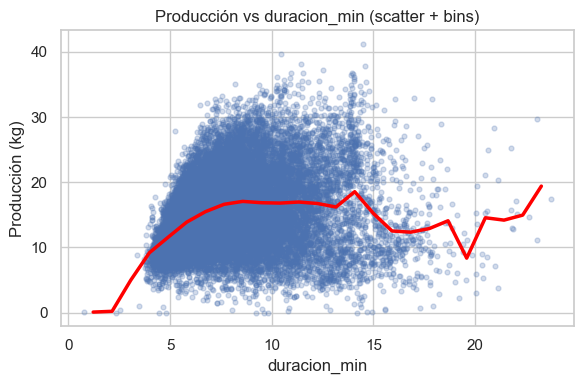

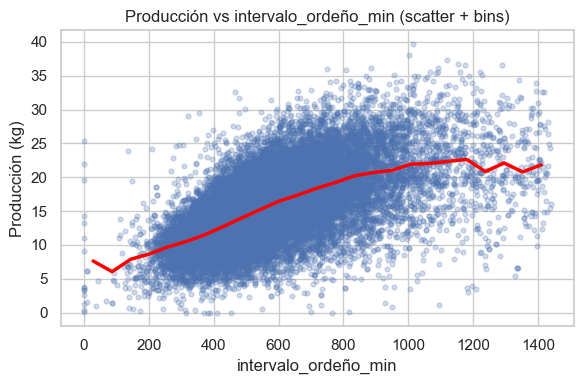

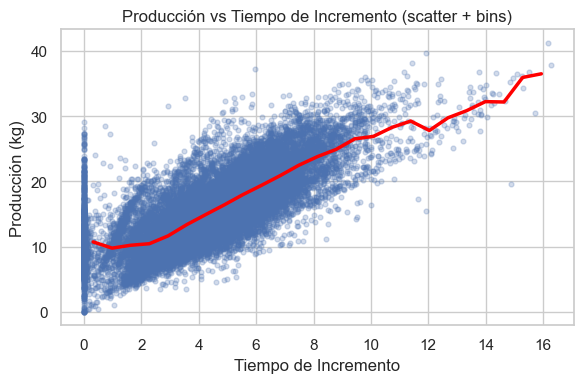

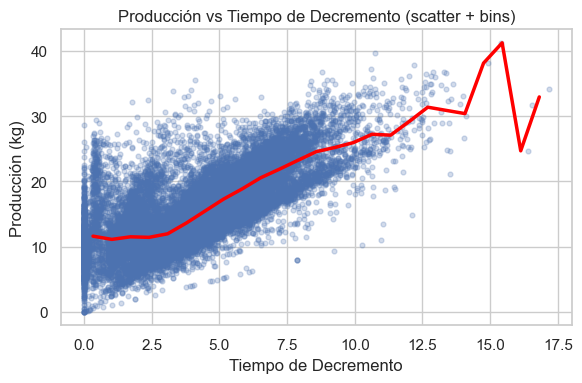

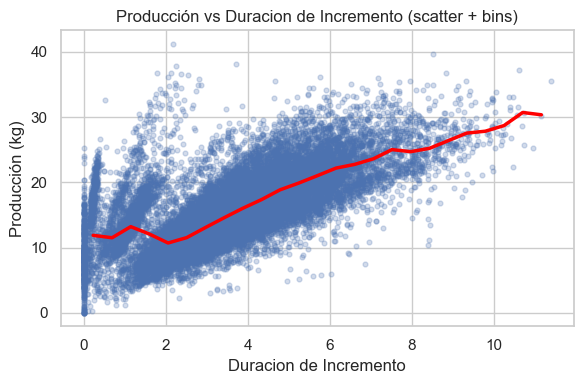

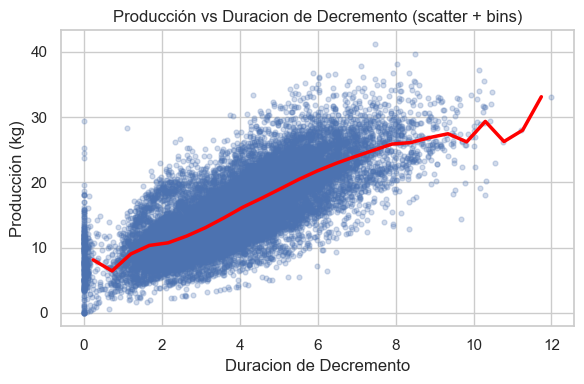

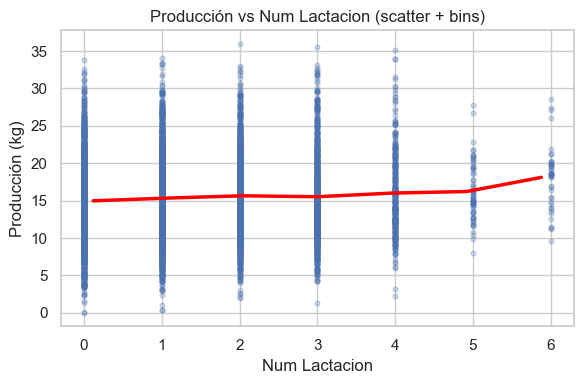

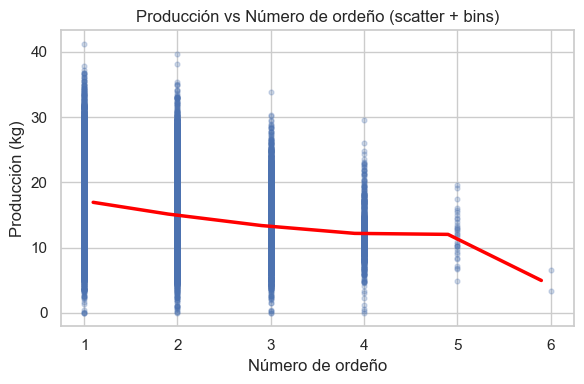

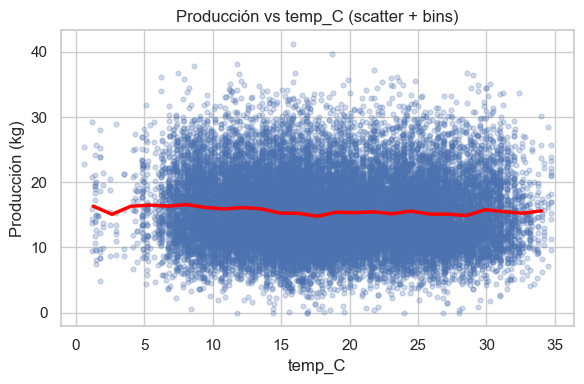

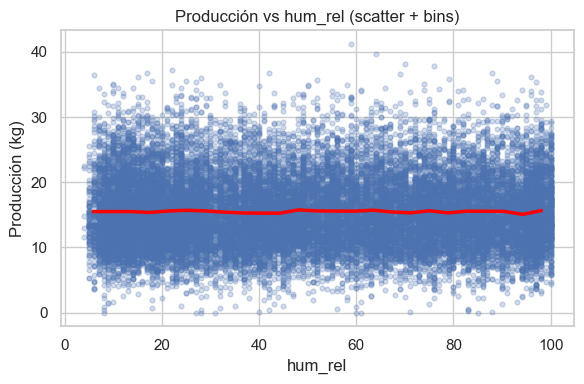

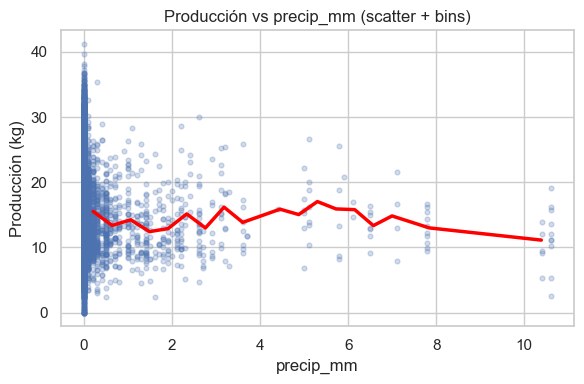

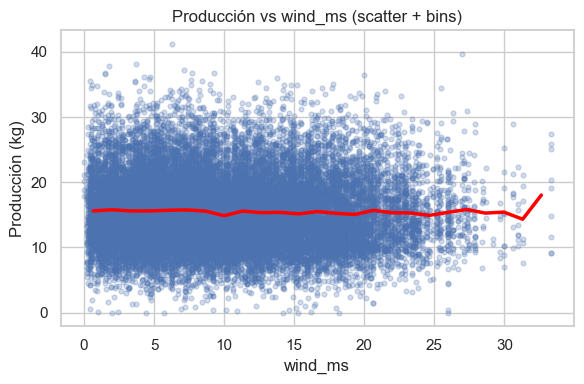

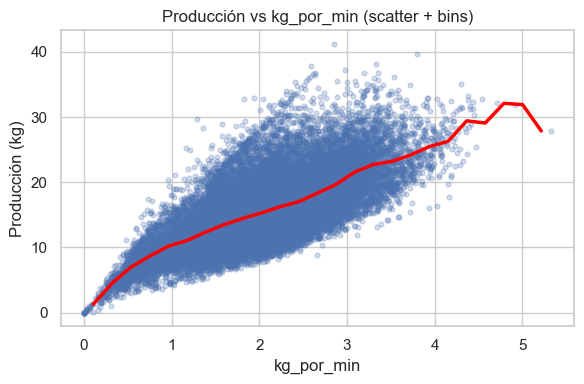

In [19]:
def binned_curve(x, y, bins=20):
    """Curva de respuesta por bins (media por bin) para interpretación operativa."""
    tmp = pd.DataFrame({"x": x, "y": y}).dropna()
    if len(tmp) < 50:
        return None
    tmp["bin"] = pd.cut(tmp["x"], bins=bins)
    g = tmp.groupby("bin", observed=True)["y"].mean()
    xmid = [iv.mid for iv in g.index]
    return np.array(xmid), g.values

# Scatter simple + curva bins
for v in vars_scatter:
    x = plot_df[v]
    yv = plot_df[target_col]
    m = x.notna() & yv.notna()
    if m.sum() < 50:
        continue

    plt.figure(figsize=(6,4))
    plt.scatter(x[m], yv[m], alpha=0.25, s=12)
    out = binned_curve(x[m], yv[m], bins=25)
    if out is not None:
        xm, ym = out
        plt.plot(xm, ym, color="red", linewidth=2.5, zorder=3)
    plt.title(f"Producción vs {v} (scatter + bins)")
    plt.xlabel(v)
    plt.ylabel("Producción (kg)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


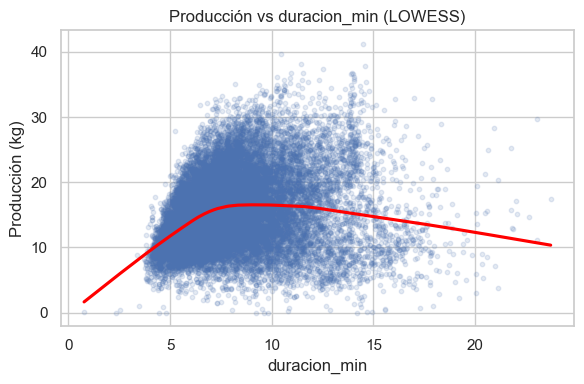

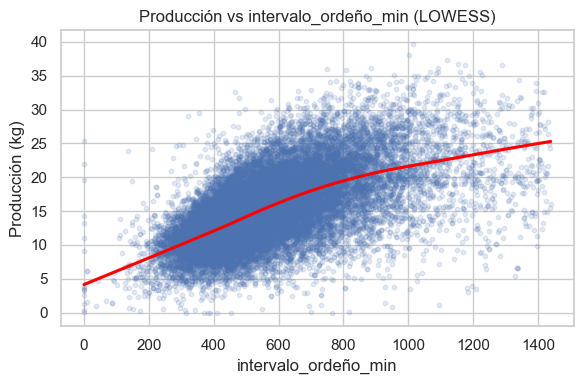

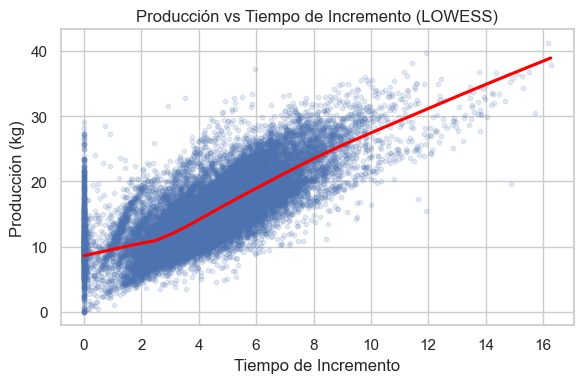

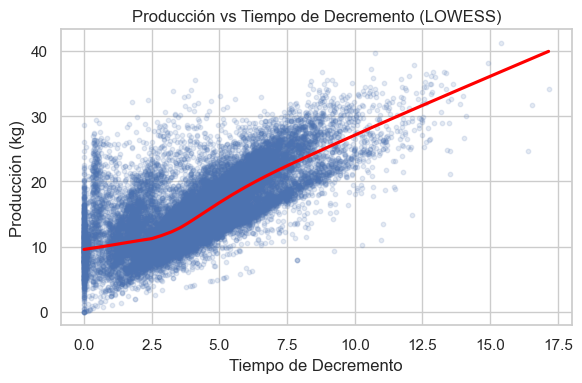

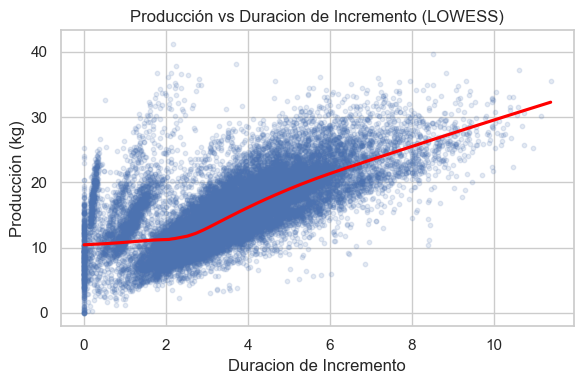

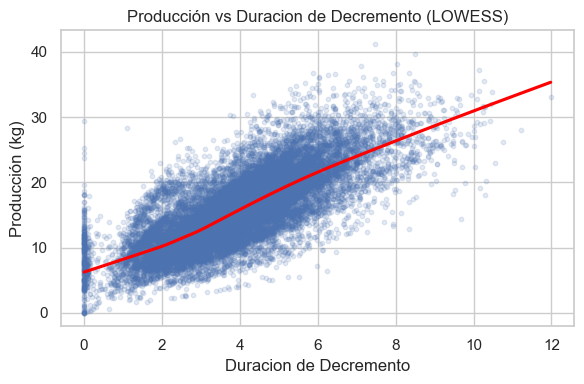

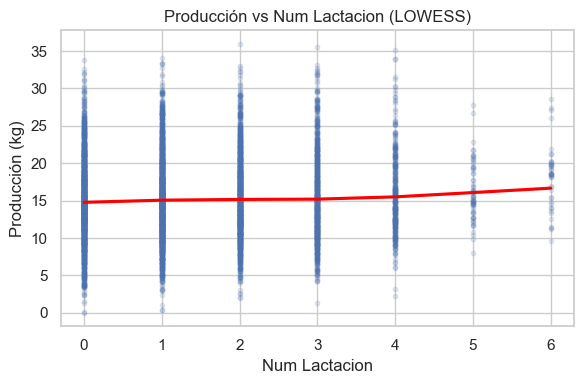

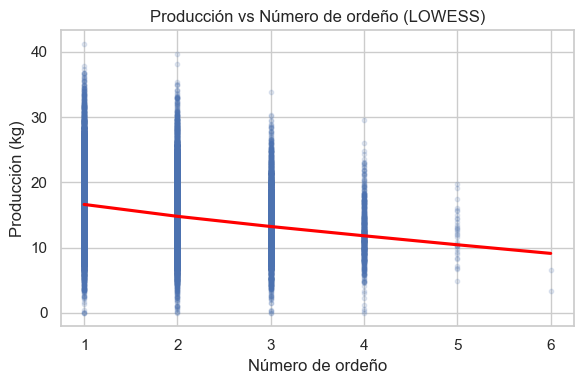

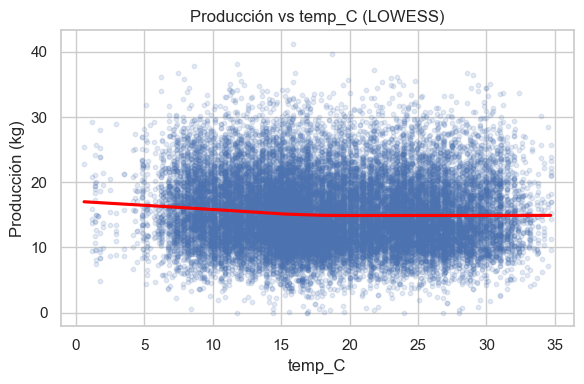

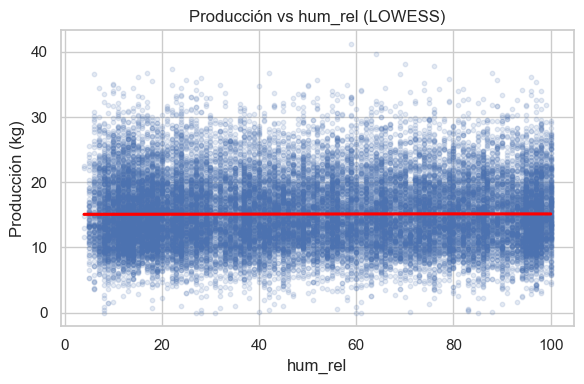

/Users/josemanuelromoperedo/Desktop/ProyectoGranja/venv/lib/python3.13/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


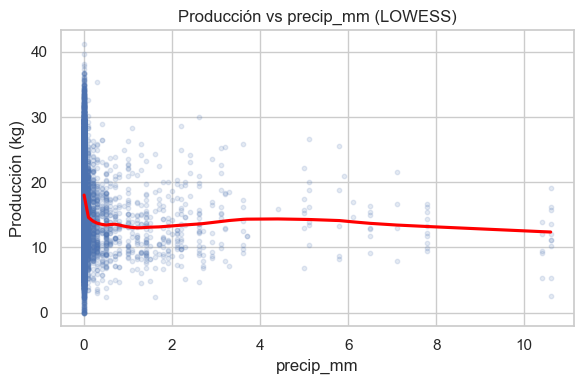

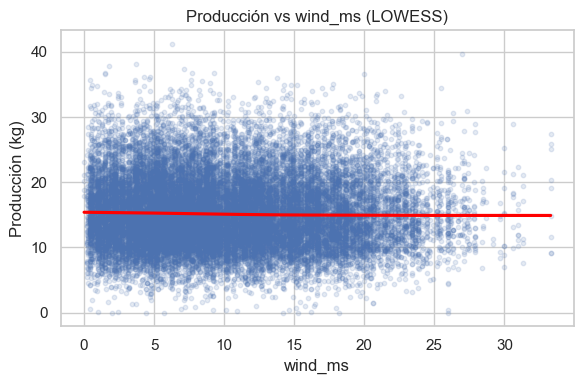

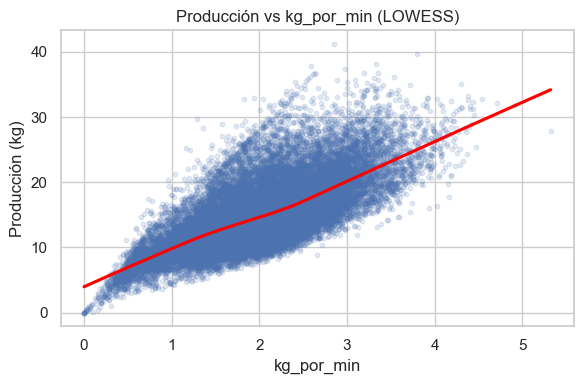

In [20]:
# LOWESS (opcional): requiere statsmodels
if HAVE_SNS and HAVE_STATSMODELS:
    for v in vars_scatter:
        x = plot_df[v]
        yv = plot_df[target_col]
        m = x.notna() & yv.notna()
        if m.sum() < 200:
            continue
        plt.figure(figsize=(6,4))
        sns.regplot(
            x=x[m],
            y=yv[m],
            lowess=True,
            scatter_kws={"alpha":0.15, "s":10},
            line_kws={"color":"red"}
        )
        plt.title(f"Producción vs {v} (LOWESS)")
        plt.xlabel(v); plt.ylabel("Producción (kg)")
        plt.tight_layout()
        plt.show()
else:
    print("LOWESS omitido. Para habilitar: pip install statsmodels (y seaborn).") 


## 11) Selección de características (filtrado)

### 11.1 Umbral de varianza (VarianceThreshold)
**Justificación:** variables con varianza casi nula aportan poca información y aumentan complejidad.

### 11.2 Correlación
**Justificación:** identifica variables redundantes o poco relacionadas con el target (no implica causalidad).

### 11.3 Chi-cuadrado (con target discretizado)
**Justificación:** chi-cuadrado evalúa dependencia entre variables categóricas (one-hot) y clases.  
Para regresión, discretizamos `Producción (kg)` en bins (baja/medio/alta), para un análisis exploratorio de dependencia.


In [21]:
from sklearn.feature_selection import VarianceThreshold

# Usaremos la versión estandarizada (X_train_std) para selección y modelos lineales
# Nota: VarianceThreshold funciona sobre datos numéricos.
vt = VarianceThreshold(threshold=0.01)
Xtr_vt = vt.fit_transform(X_train_std)
Xte_vt = vt.transform(X_test_std)

kept_cols_vt = X_train_std.columns[vt.get_support()].tolist()
print("Features antes:", X_train_std.shape[1])
print("Features después (var>0.01):", len(kept_cols_vt))
kept_cols_vt[:10], " ..."


Features antes: 96
Features después (var>0.01): 60


/Users/josemanuelromoperedo/Desktop/ProyectoGranja/venv/lib/python3.13/site-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


(['duracion_s',
  'duracion_min',
  'intervalo_ordeño_min',
  'Duracion de Incremento',
  'Duracion de Decremento',
  'Tiempo de Incremento',
  'Tiempo de Decremento',
  'Ubre',
  'Número de ordeño',
  'Num Lactacion'],
 ' ...')

In [22]:
# Correlación con el target (sobre train para evitar leakage conceptual)
train_corr = pd.concat([X_train_imp[num_features], y_train.reset_index(drop=True)], axis=1).corr(numeric_only=True)[target_col]
train_corr = train_corr.drop(labels=[target_col], errors="ignore").sort_values(ascending=False)

print("Top correlaciones +:", train_corr.head(10))
print("Top correlaciones -:", train_corr.tail(10))


Top correlaciones +: doy_cos                   0.011999
precip_mm                 0.009773
Duracion de Decremento    0.008999
Número de ordeño          0.005756
is_weekend                0.005460
duracion_min              0.005187
duracion_s                0.005187
hour                      0.005132
wind_ms                   0.003863
pres_msl                  0.003081
Name: Producción (kg), dtype: float64
Top correlaciones -: Tiempo de Decremento   -0.006007
Tiempo de Incremento   -0.006681
Num Lactacion          -0.006932
dec_ratio              -0.007117
doy_sin                -0.007416
month                  -0.007951
hour_cos               -0.008914
inc_ratio              -0.009465
dayofyear              -0.011343
Pezón                        NaN
Name: Producción (kg), dtype: float64


In [24]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# 1) Discretizar y (regresión -> clases) para poder aplicar chi2
y_train_bins = pd.qcut(y_train, q=3, labels=["baja", "media", "alta"])

# 2) Construir X no-negativa y SIN NaN
#    Partimos de la versión imputada (X_train_imp) que ya tiene numéricas rellenadas.
X_chi = X_train_imp.copy()

# Asegurar que no quede ningún NaN (por si alguna columna estaba completamente vacía)
X_chi = X_chi.fillna(0)

# 3) Chi2 requiere X >= 0. Usamos MinMax para llevar todo a [0, 1]
scaler = MinMaxScaler()
X_chi_mm = pd.DataFrame(
    scaler.fit_transform(X_chi),
    columns=X_chi.columns,
    index=X_chi.index
)

# 4) Calcular chi2
chi2_vals, p_vals = chi2(X_chi_mm, y_train_bins)

chi2_df = pd.DataFrame({
    "feature": X_chi_mm.columns,
    "chi2": chi2_vals,
    "p_value": p_vals
}).sort_values("chi2", ascending=False)

chi2_df.head(15)


,feature,chi2,p_value
85,"duracion_bin_q_(0.766, 5.917]",1423.597280,7.409322e-310
6,Tiempo de Decremento,528.336910,1.875416e-115
3,Duracion de Incremento,523.217136,2.425731e-114
4,Duracion de Decremento,482.227360,1.930453e-105
5,Tiempo de Incremento,472.412381,2.611890e-103
25,kg_por_min,412.587593,2.557070e-90
88,"duracion_bin_q_(8.033, 9.767]",315.405920,3.239476e-69
2,intervalo_ordeño_min,287.655358,3.439005e-63
27,dec_ratio,244.675721,7.401882e-54
7,Ubre,235.625168,6.833525e-52


## 12) Selección ANOVA (F-test) para regresión

### Justificación
ANOVA/F-test (`f_regression`) mide qué tan bien cada feature explica el target (linealmente) de manera univariada.  
Es un método de filtrado rápido y fundamentado para regresión.


In [26]:
from sklearn.feature_selection import f_regression
import numpy as np
import pandas as pd

# 1) Partimos de la versión imputada (sin NaNs en la mayoría de casos)
X_anova = X_train_imp.copy()

# 2) Asegurar que NO quede ningún NaN (por columnas totalmente vacías)
#    - columnas completamente NaN -> las quitamos (no aportan)
all_nan_cols = X_anova.columns[X_anova.isna().all()].tolist()
if len(all_nan_cols) > 0:
    print("Eliminando columnas 100% NaN:", all_nan_cols[:10], "..." if len(all_nan_cols) > 10 else "")
    X_anova = X_anova.drop(columns=all_nan_cols)

# 3) Rellenar NaNs residuales (si existieran) con 0
X_anova = X_anova.fillna(0)

# 4) Eliminar columnas constantes (varianza ~ 0), f_regression no da info útil ahí
stds = X_anova.std(numeric_only=True)
const_cols = stds[stds < 1e-12].index.tolist()
if len(const_cols) > 0:
    print("Eliminando columnas constantes:", const_cols[:10], "..." if len(const_cols) > 10 else "")
    X_anova = X_anova.drop(columns=const_cols)

# 5) f_regression
F, p = f_regression(X_anova, y_train)

anova_df = pd.DataFrame({
    "feature": X_anova.columns,
    "F": F,
    "p_value": p
}).sort_values("F", ascending=False)

anova_df.head(15)


Eliminando columnas 100% NaN: ['Pezón'] 
Eliminando columnas constantes: ['Destino Leche_nan', 'MS_nan', 'Usuario_nan'] 


,feature,F,p_value
4,Duracion de Decremento,26752.632701,0.000000e+00
5,Tiempo de Incremento,22316.412969,0.000000e+00
6,Tiempo de Decremento,20639.627085,0.000000e+00
24,kg_por_min,18511.831683,0.000000e+00
3,Duracion de Incremento,15650.312905,0.000000e+00
2,intervalo_ordeño_min,10278.279894,0.000000e+00
25,inc_ratio,7394.374360,0.000000e+00
26,dec_ratio,6347.356064,0.000000e+00
81,"duracion_bin_q_(0.766, 5.917]",1766.252052,0.000000e+00
8,Número de ordeño,1523.393986,0.000000e+00


## 13) Extracción de características: PCA y Factor Analysis

### 13.1 PCA
**Justificación:** reduce dimensionalidad, elimina multicolinealidad y acelera entrenamiento, conservando varianza.

### 13.2 Factor Analysis (FA)
**Justificación:** modela factores latentes; útil cuando se asume que variables observadas dependen de pocos factores subyacentes.

> Nota: PCA/FA se aplican típicamente a variables numéricas escaladas.


In [28]:
from sklearn.feature_selection import f_regression
import numpy as np
import pandas as pd

# 1) Partimos de la versión imputada (sin NaNs en la mayoría de casos)
X_anova = X_train_imp.copy()

# 2) Asegurar que NO quede ningún NaN (por columnas totalmente vacías)
#    - columnas completamente NaN -> las quitamos (no aportan)
all_nan_cols = X_anova.columns[X_anova.isna().all()].tolist()
if len(all_nan_cols) > 0:
    print("Eliminando columnas 100% NaN:", all_nan_cols[:10], "..." if len(all_nan_cols) > 10 else "")
    X_anova = X_anova.drop(columns=all_nan_cols)

# 3) Rellenar NaNs residuales (si existieran) con 0
X_anova = X_anova.fillna(0)

# 4) Eliminar columnas constantes (varianza ~ 0), f_regression no da info útil ahí
stds = X_anova.std(numeric_only=True)
const_cols = stds[stds < 1e-12].index.tolist()
if len(const_cols) > 0:
    print("Eliminando columnas constantes:", const_cols[:10], "..." if len(const_cols) > 10 else "")
    X_anova = X_anova.drop(columns=const_cols)

# 5) f_regression
F, p = f_regression(X_anova, y_train)

anova_df = pd.DataFrame({
    "feature": X_anova.columns,
    "F": F,
    "p_value": p
}).sort_values("F", ascending=False)

anova_df.head(15)


Eliminando columnas 100% NaN: ['Pezón'] 
Eliminando columnas constantes: ['Destino Leche_nan', 'MS_nan', 'Usuario_nan'] 


,feature,F,p_value
4,Duracion de Decremento,26752.632701,0.000000e+00
5,Tiempo de Incremento,22316.412969,0.000000e+00
6,Tiempo de Decremento,20639.627085,0.000000e+00
24,kg_por_min,18511.831683,0.000000e+00
3,Duracion de Incremento,15650.312905,0.000000e+00
2,intervalo_ordeño_min,10278.279894,0.000000e+00
25,inc_ratio,7394.374360,0.000000e+00
26,dec_ratio,6347.356064,0.000000e+00
81,"duracion_bin_q_(0.766, 5.917]",1766.252052,0.000000e+00
8,Número de ordeño,1523.393986,0.000000e+00


In [30]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# 1) Partimos de la versión imputada (sin NaNs en numéricas, y 0 en one-hot)
X_fa_train = X_train_imp.copy()
X_fa_test  = X_test_imp.copy()

# 2) Eliminar columnas 100% NaN (si las hay)
all_nan_cols = X_fa_train.columns[X_fa_train.isna().all()].tolist()
if len(all_nan_cols) > 0:
    print("Eliminando columnas 100% NaN:", all_nan_cols[:10], "..." if len(all_nan_cols) > 10 else "")
    X_fa_train = X_fa_train.drop(columns=all_nan_cols)
    X_fa_test  = X_fa_test.drop(columns=all_nan_cols)

# 3) Rellenar cualquier NaN residual (por seguridad)
X_fa_train = X_fa_train.fillna(0)
X_fa_test  = X_fa_test.fillna(0)

# 4) Eliminar columnas constantes (FA no aprende nada de columnas constantes)
stds = X_fa_train.std(numeric_only=True)
const_cols = stds[stds < 1e-12].index.tolist()
if len(const_cols) > 0:
    print("Eliminando columnas constantes:", const_cols[:10], "..." if len(const_cols) > 10 else "")
    X_fa_train = X_fa_train.drop(columns=const_cols)
    X_fa_test  = X_fa_test.drop(columns=const_cols)

# 5) Escalar (muy importante para FA)
scaler = StandardScaler()
X_fa_train_std = scaler.fit_transform(X_fa_train)
X_fa_test_std  = scaler.transform(X_fa_test)

# 6) Elegir número de factores (heurística simple)
n_factors = min(10, X_fa_train_std.shape[1])
fa = FactorAnalysis(n_components=n_factors, random_state=RANDOM_SEED)

Xtr_fa = fa.fit_transform(X_fa_train_std)
Xte_fa = fa.transform(X_fa_test_std)

print("Factores FA:", Xtr_fa.shape[1])


Eliminando columnas 100% NaN: ['Pezón'] 
Eliminando columnas constantes: ['Destino Leche_nan', 'MS_nan', 'Usuario_nan'] 
Factores FA: 10


## 14) Baseline de modelos (validación rápida)

### Justificación
Aunque el foco es Data Preparation, un baseline permite:
- verificar que las transformaciones generan señal útil
- comparar representaciones (raw imputado vs estandarizado vs PCA)

Evaluamos con:
- **MAE** (kg): interpretabilidad operativa
- **R²**: referencia de varianza explicada


In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
import numpy as np

# ============================
# Limpieza robusta para sklearn
# ============================
def MakeSklearnSafe(Xtr: pd.DataFrame, Xte: pd.DataFrame):
    Xtr2 = Xtr.copy()
    Xte2 = Xte.copy()

    # 1) Eliminar columnas 100% NaN en train
    all_nan_cols = Xtr2.columns[Xtr2.isna().all()].tolist()
    if len(all_nan_cols) > 0:
        print("Eliminando columnas 100% NaN:", all_nan_cols[:10], "..." if len(all_nan_cols) > 10 else "")
        Xtr2 = Xtr2.drop(columns=all_nan_cols)
        Xte2 = Xte2.drop(columns=all_nan_cols)

    # 2) Imputación simple: numéricas con mediana, categóricas/one-hot con 0
    num_cols = Xtr2.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in Xtr2.columns if c not in num_cols]

    med = Xtr2[num_cols].median(numeric_only=True)
    # Si alguna mediana sale NaN (columna vacía), rellenarla con 0
    med = med.fillna(0)

    Xtr2[num_cols] = Xtr2[num_cols].fillna(med)
    Xte2[num_cols] = Xte2[num_cols].fillna(med)

    Xtr2[other_cols] = Xtr2[other_cols].fillna(0)
    Xte2[other_cols] = Xte2[other_cols].fillna(0)

    # 3) Eliminar columnas constantes (varianza ~ 0) para modelos lineales/PCA/FA
    stds = Xtr2[num_cols].std(numeric_only=True)
    const_cols = stds[stds < 1e-12].index.tolist()
    if len(const_cols) > 0:
        print("Eliminando columnas constantes:", const_cols[:10], "..." if len(const_cols) > 10 else "")
        Xtr2 = Xtr2.drop(columns=const_cols)
        Xte2 = Xte2.drop(columns=const_cols)
        num_cols = [c for c in num_cols if c not in const_cols]

    # 4) Safety check: ya no debe haber NaNs
    if Xtr2.isna().any().any() or Xte2.isna().any().any():
        # si queda algo raro, lo rellenamos con 0
        print("Advertencia: quedaban NaNs residuales; rellenando con 0.")
        Xtr2 = Xtr2.fillna(0)
        Xte2 = Xte2.fillna(0)

    return Xtr2, Xte2, num_cols

# Construcción segura
X_train_safe, X_test_safe, num_features_safe = MakeSklearnSafe(X_train, X_test)

# StandardScaler
scaler_std = StandardScaler()
X_train_std = X_train_safe.copy()
X_test_std  = X_test_safe.copy()
X_train_std[num_features_safe] = scaler_std.fit_transform(X_train_safe[num_features_safe])
X_test_std[num_features_safe]  = scaler_std.transform(X_test_safe[num_features_safe])

# MinMaxScaler (para chi2)
scaler_mm = MinMaxScaler()
X_train_mm = pd.DataFrame(
    scaler_mm.fit_transform(X_train_safe),
    columns=X_train_safe.columns,
    index=X_train_safe.index
)
X_test_mm = pd.DataFrame(
    scaler_mm.transform(X_test_safe),
    columns=X_test_safe.columns,
    index=X_test_safe.index
)

# Yeo–Johnson (opcional): aplicar solo a numéricas seguras
pt = PowerTransformer(method="yeo-johnson", standardize=True)
X_train_yj = X_train_safe.copy()
X_test_yj  = X_test_safe.copy()
if len(num_features_safe) > 0:
    X_train_yj[num_features_safe] = pt.fit_transform(X_train_safe[num_features_safe])
    X_test_yj[num_features_safe]  = pt.transform(X_test_safe[num_features_safe])

print("Listo:", 
      "X_train_std", X_train_std.shape,
      "| X_train_mm", X_train_mm.shape,
      "| X_train_yj", X_train_yj.shape)


Eliminando columnas 100% NaN: ['Pezón'] 
Listo: X_train_std (19386, 95) | X_train_mm (19386, 95) | X_train_yj (19386, 95)


## 15) Conclusiones — Data Preparation en CRISP-ML

### Síntesis
En la fase **Data Preparation** (CRISP-ML) se realizaron transformaciones para convertir datos crudos en un dataset apto para ML:

1. **Estandarización de formato temporal** (timestamps) y limpieza mínima para consistencia.
2. **Generación de características**:
   - temporales (hora, día de semana, estacionalidad cíclica),
   - eficiencia/dinámica del proceso (kg/min, ratios de rampas),
   - enriquecimiento con clima (variables exógenas).
3. **Discretización (binning)** para análisis interpretables por rangos.
4. **Codificación** de categóricas mediante one-hot y frequency encoding para evitar explosión dimensional.
5. **Mitigación de sesgos y aceleración de convergencia**:
   - escalamiento (StandardScaler, MinMax),
   - transformaciones (Yeo–Johnson, log implícito vía PowerTransformer).
6. **Selección / extracción**:
   - filtrado por varianza, correlación, chi-cuadrado (con target discretizado),
   - ANOVA para regresión,
   - PCA y Factor Analysis para reducción de dimensionalidad.

### Impacto
- Se redujo el riesgo de **features sesgadas por escala** y se habilitó el uso de modelos sensibles a normalización.
- Se redujo complejidad (PCA/FA) y se obtuvieron criterios de priorización (ANOVA/chi2).
- La exploración con scatter + curvas por bins facilita identificar **palancas de proceso** para optimización (ej. duración, intervalos, rampas) bajo condiciones ambientales.

---

## Próximos pasos (Modeling / Optimization)
- Entrenar modelos con validación cruzada y ajuste de hiperparámetros.
- Interpretabilidad (importancias/SHAP) enfocada en variables **controlables**.
- Optimización: búsqueda de máximos de `Producción` sujeto a restricciones operativas (duración, intervalos, etc.).


## 16) Export de artefactos (opcional)

Se exporta un dataset engineered para usar en etapas posteriores (modeling/optimization).  
En el repo, lo ideal es exportar a `data/processed/` y versionar solo si el tamaño lo permite.


In [ ]:
engineered = X.copy()
engineered[target_col] = y

OUT = Path("/mnt/data/engineered_produccion_avance2.csv")
engineered.to_csv(OUT, index=False)

print("Exportado:", OUT)
engineered.head()


---

### Nota final para entrega
Antes de subir a GitHub:
1. **Kernel → Restart & Run All**
2. Verifica que no hay errores y que corre en orden.
3. Renombra el archivo a: `Avance2.#Equipo.ipynb` (con tu número real).
